In [35]:
import os

from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import torch
from torchvision.utils import make_grid
from tqdm import tqdm

In [36]:
breed = "data/breed.csv"
filename = "data/labels.csv"
labelsNames = ["id", "breed"]
labels = read_csv(filename, names=labelsNames)

breedNames = read_csv(breed)["breed"].tolist()[1:]
print(labels.shape)
# print(len(breedNames))

(12001, 2)


In [37]:
le = LabelEncoder()
le.fit(list(set(labels["breed"].tolist()[1:])))
data_label = le.transform(labels["breed"].tolist()[1:])
print(len(data_label))

12000


In [38]:

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),  # 添加随机旋转
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # 添加颜色抖动
            transforms.RandomGrayscale(p=0.2),  # 随机将部分图像转换为灰度
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),
        ]
    ),
}

In [39]:
from sklearn.model_selection import train_test_split

labels_files = labels["id"].apply(lambda x: os.getcwd()+"/data/train/" + x + ".jpg").tolist()[1:]
train_path, val_path, train_label, val_label = train_test_split(
    labels_files, data_label, test_size=0.2
)


In [40]:
from torch.utils.data import Dataset


class DogDataset(Dataset):
    def __init__(self, data_path, data_label, transform=None):
        """
        - data_path (string): 图片路径
        - data_label (string): 图片标签
        - transform (callable, optional): 作用在每个样本上的预处理函数
        """
        self.data_path = data_path
        self.data_label = data_label
        self.transform = transform

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, idx):
        img_path = self.data_path[idx]
        image = io.imread(img_path)
        label = self.data_label[idx]

        # 如果有，则对数据预处理
        if self.transform:
            image = self.transform(image)

        return image, label

In [41]:
train_dataset = DogDataset(train_path, train_label, data_transforms["train"])
val_dataset = DogDataset(val_path, val_label, data_transforms["val"])


# 训练数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# 验证数据加载器
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


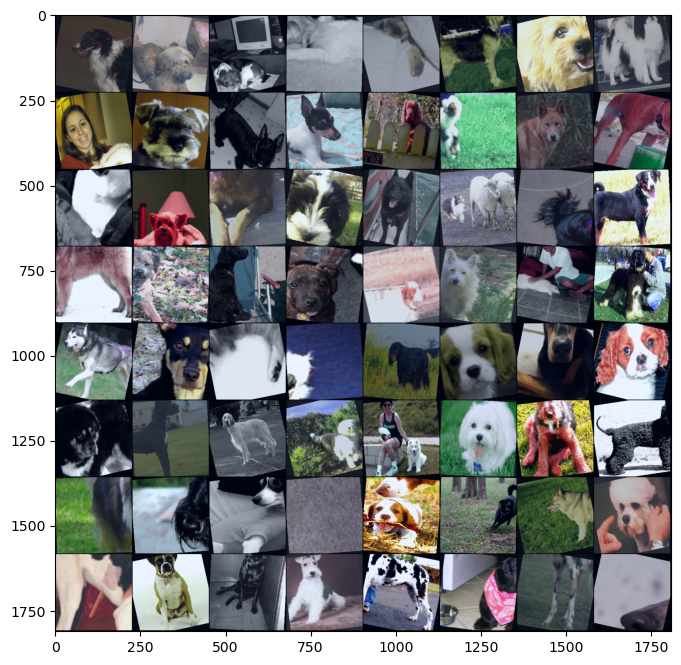

In [42]:

for batch_index, sample_batch in enumerate(train_loader):
    images, labels = sample_batch
    sample_images = make_grid(images, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(sample_images.permute(1, 2, 0).numpy())
    break

In [58]:
from torchvision import models

# 从课程镜像服务器上下载 convnext 预训练模型
convnext = models.convnext_large(weights='IMAGENET1K_V1')
vgg19 = models.vgg19_bn(pretrained=True)
efficientnet = models.efficientnet_b7(pretrained=True)
regnet_y_16gf = models.regnet_y_16gf(pretrained=True)

# 冻结模型的参数
for model in [convnext, vgg19, efficientnet, regnet_y_16gf]:
    for param in model.parameters():
        param.requires_grad = False

# 修改分类器部分，适应你的任务（120种狗的分类任务）

regnet_y_16gf

E:\Program\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_16GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_16GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_16gf-9e6ed7dd.pth" to C:\Users\17164/.cache\torch\hub\checkpoints\regnet_y_16gf-9e6ed7dd.pth
100%|██████████| 319M/319M [00:39<00:00, 8.39MB/s] 


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [51]:
# for param in convnext.parameters():
#     param.requires_grad = False
#     # print(param.requires_grad)
#     
# # 
# # for layer in list(convnext.features.children())[-1:]:
# #     for param in layer.parameters():
# #         param.requires_grad = True
# 
# 
# 
# for param in convnext.parameters():
#     # param.requires_grad = False
#     print(param.requires_grad)

In [59]:
classifier = list(convnext.classifier.children())  # 读取分类器全部层
classifier[-1] = torch.nn.Linear(1536, 120)
classifier.append(torch.nn.Softmax(dim=1))  # 添加 LogSoftmax 层
convnext.classifier = torch.nn.Sequential(*classifier)  # 修改原分类器

classifier = list(vgg19.classifier.children())  # 读取分类器全部层
classifier[-1] = torch.nn.Linear(4096, 120)
classifier.append(torch.nn.Softmax(dim=1))  # 添加 LogSoftmax 层
vgg19.classifier = torch.nn.Sequential(*classifier)  # 修改原分类器

regnet_y_16gf.fc = torch.nn.Linear(3024, 120)

classifier = list(efficientnet.classifier.children())  # 读取分类器全部层
classifier[-1] = torch.nn.Linear(2560, 120)
classifier.append(torch.nn.Softmax(dim=1))  # 添加 LogSoftmax 层
efficientnet.classifier = torch.nn.Sequential(*classifier)  # 修改原分类器





In [60]:
dev = torch.device("cuda") 

In [61]:
from adabound import adabound
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class LabelSmoothingLoss(torch.nn.Module):
    def __init__(self, classes, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.classes = classes
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), confidence)
        return torch.mean(torch.sum(-true_dist * torch.log_softmax(pred, dim=-1), dim=-1))

criterion = LabelSmoothingLoss(classes=120, smoothing=0.1)



# optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, convnext.parameters()), lr=0.00005
# )  # 优化器
# # 学习率衰减，每迭代 1 次，衰减为初始学习率 0.5
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9995)
# optimizer = torch.optim.AdamW(convnext.parameters(), lr=0.00005, weight_decay=1e-4)
# optimizer = adabound.AdaBound(convnext.parameters(), lr=1e-3, final_lr=0.1)
learning_rate = 1e-3
convnext_optimizer = torch.AdamW(convnext.parameters(), lr=learning_rate)
vgg19_optimizer = torch.optim.AdamW(vgg19.parameters(), lr=learning_rate)
efficientnet_optimizer = torch.optim.AdamW(efficientnet.parameters(), lr=learning_rate)
regnet_y_16gf_optimizer = torch.optim.AdamW(regnet_y_16gf.parameters(), lr=learning_rate)


optimizer = adabound.AdaBound(
    list(convnext.classifier.parameters()) + 
    list(vgg19.classifier.parameters()) + 
    list(efficientnet.classifier.parameters())+
    list(regnet_y_16gf.fc.parameters()), 
    lr=1e-3, final_lr=0.1
)
# 定义 CosineAnnealingWarmRestarts 学习率调度器
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)



criterion, optimizer, scheduler

(LabelSmoothingLoss(),
 AdaBound (
 Parameter Group 0
     amsbound: False
     betas: (0.9, 0.999)
     eps: 1e-08
     final_lr: 0.1
     gamma: 0.001
     initial_lr: 0.001
     lr: 0.001
     weight_decay: 0
 ),
 <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts at 0x1546db1e910>)

In [63]:
import random
import torch
import numpy as np

def mosaic_data(images, labels, input_size=224):
    """
    使用 Mosaic 数据增强技术生成新的图像和标签。
    :param images: 当前 batch 的图像张量，形状为 [batch_size, channels, height, width]
    :param labels: 当前 batch 的标签张量
    :param input_size: 输出图像的目标尺寸
    :return: 增强后的图像和标签
    """
    batch_size, channels, height, width = images.size()
    new_image = torch.zeros((batch_size, channels, input_size, input_size), device=images.device)
    new_labels = torch.zeros((batch_size,), dtype=torch.long, device=labels.device)
    
    for i in range(batch_size):
        # 随机选择四张图像
        indices = torch.randperm(batch_size)[:4]
        selected_images = images[indices]
        selected_labels = labels[indices]

        # 定义要切割的每个区域大小
        cut_x = random.randint(int(input_size * 0.4), int(input_size * 0.6))
        cut_y = random.randint(int(input_size * 0.4), int(input_size * 0.6))
        
        # 将四张图像拼接成一张图像
        new_image[i, :, :cut_y, :cut_x] = selected_images[0, :, :cut_y, :cut_x]
        new_image[i, :, :cut_y, cut_x:] = selected_images[1, :, :cut_y, cut_x:]
        new_image[i, :, cut_y:, :cut_x] = selected_images[2, :, cut_y:, :cut_x]
        new_image[i, :, cut_y:, cut_x:] = selected_images[3, :, cut_y:, cut_x:]
        
        # 对应的标签采用随机选择的方式
        new_labels[i] = selected_labels[random.randint(0, 3)]
    
    return new_image, new_labels

In [65]:
import torch
from torch.cuda.amp import GradScaler, autocast
import os
from tqdm import tqdm

epochs = 100
convnext_model = convnext.to(dev)
vgg19_model = vgg19.to(dev)
efficientnet_model = efficientnet.to(dev)
regnet_y_16gf_model = regnet_y_16gf.to(dev)
print("Start Training...")

if os.path.exists("models/convnext.pt"):  # 检查是否存在预训练模型
    model_saved = convnext.to(dev)
    model_saved.load_state_dict(torch.load("models/convnext.pt"))
    model = model_saved.to(dev)
    print("Load model from convnext.pt")
    
if os.path.exists("models/vgg19.pt"):  # 检查是否存在预训练模型
    model_saved = vgg19.to(dev)
    model_saved.load_state_dict(torch.load("models/vgg19.pt"))
    model = model_saved.to(dev)
    print("Load model from vgg19.pt")

if os.path.exists("models/efficientnet.pt"):  # 检查是否存在预训练模型
    model_saved = efficientnet.to(dev)
    model_saved.load_state_dict(torch.load("models/efficientnet.pt"))
    model = model_saved.to(dev)
    print("Load model from efficientnet.pt")
    
if os.path.exists("models/regnet_y_16gf.pt"):  # 检查是否存在预训练模型
    model_saved = regnet_y_16gf.to(dev)
    model_saved.load_state_dict(torch.load("models/regnet_y_16gf.pt"))
    model = model_saved.to(dev)
    print("Load model from regnet_y_16gf.pt")

models_ensemble = [convnext_model, vgg19_model, efficientnet_model, regnet_y_16gf_model]
# 初始化 GradScaler
scaler = GradScaler()

convnext_weight = 3.0
other_weight = 1.0

for epoch in range(epochs):
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(dev)
        labels = labels.to(dev)

        optimizer.zero_grad()
        
        # if np.random.rand() < 0.5:
        #     images, labels = mosaic_data(images, labels, input_size=224)
        # 使用 autocast 进行前向和反向传递
        with autocast():
            outputs_convnext = convnext(images) * convnext_weight
            outputs_other = sum(model(images) for model in models_ensemble[1:]) * other_weight
            avg_output = (outputs_convnext + outputs_other) / (convnext_weight + other_weight * (len(models_ensemble) - 1))
            loss = criterion(avg_output, labels.type(torch.int64))


        # 使用 GradScaler 来缩放损失并进行反向传播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()  # 更新 scaler

        if (i + 1) % 100 == 0:
            print(
                "Epoch [{}/{}], Batch [{}/{}], Train loss: {:.3f}".format(
                    epoch + 1, epochs, i + 1, len(train_loader), loss.item()
                )
            )

    correct = 0
    total = 0
    # if epoch % 10 == 0:
    #     for idx, model in enumerate(models_ensemble):
    #         torch.save(model.state_dict(), f"models/model_{idx}_epoch_{epoch}.pt")

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(dev)
            labels = labels.to(dev)

            with autocast():
                outputs_convnext = convnext(images) * convnext_weight
                outputs_other = sum(model(images) for model in models_ensemble[1:]) * other_weight
                avg_output = (outputs_convnext + outputs_other) / (convnext_weight + other_weight * (len(models_ensemble) - 1))
                _, predicted = torch.max(avg_output.data, 1)


            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print("============ Test accuracy: {:.3f} =============".format(correct / total))

    scheduler.step()  # 设置学习率衰减

Start Training...


C:\Users\17164\AppData\Local\Temp\ipykernel_46988\3058122444.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_saved.load_state_dict(torch.load("models/convnext.pt"

Load model from convnext.pt


0it [00:00, ?it/s]C:\Users\17164\AppData\Local\Temp\ipykernel_46988\3058122444.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100it [02:19,  1.75s/it]

Epoch [1/100], Batch [100/150], Train loss: 2.931


150it [03:44,  1.49s/it]
  0%|          | 0/38 [00:00<?, ?it/s]C:\Users\17164\AppData\Local\Temp\ipykernel_46988\3058122444.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


============ Test accuracy: 0.935 =============


100it [02:46,  1.70s/it]

Epoch [2/100], Batch [100/150], Train loss: 2.788


150it [04:10,  1.67s/it]
100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


============ Test accuracy: 0.933 =============


100it [03:03,  1.66s/it]

Epoch [3/100], Batch [100/150], Train loss: 3.103


150it [04:20,  1.73s/it]
100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


============ Test accuracy: 0.928 =============


27it [00:44,  1.66s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(convnext_model.state_dict(), "models/convnext.pt")
torch.save(vgg19_model.state_dict(), "models/vgg19.pt")
torch.save(efficientnet_model.state_dict(), "models/efficientnet.pt")
torch.save(regnet_y_16gf_model.state_dict(), "models/regnet_y_16gf.pt")

In [ ]:
from PIL import Image
IMAGE = io.imread("data/train/0AjbbdBwNiGqWo5n.jpg")
IMAGE = data_transforms["val"](IMAGE).unsqueeze(0)  # PyTorch 模型输入必须为 B*C*H*W

IMAGE.size()


In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def visualize_inference_errors(model, val_loader, label_encoder, device):
    model.eval()  # 设置模型为评估模式
    errors = []  # 用于存储错误分类的样本
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # 模型预测
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # 找出错误分类的索引
            error_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            
            # 记录错误样本的信息
            for idx in error_indices:
                errors.append((images[idx].cpu(), labels[idx].cpu(), predicted[idx].cpu()))

    # 可视化错误分类的样本
    if errors:
        print(f"Number of misclassified samples: {len(errors)}")
        
        # 我们可以显示前几个错误分类的样本
        num_samples_to_show = min(len(errors), 16)  # 最多显示16个样本
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
        fig.suptitle("Misclassified Samples", fontsize=16)
        
        for i in range(num_samples_to_show):
            img, true_label, pred_label = errors[i]
            img = img.permute(1, 2, 0)  # 将图片的维度调整为 H*W*C 以便于显示
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # 反归一化
            
            ax = axes[i // 4, i % 4]
            ax.imshow(img.numpy())
            ax.set_title(f"True: {label_encoder.inverse_transform([true_label.item()])[0]}\nPred: {label_encoder.inverse_transform([pred_label.item()])[0]}")
            ax.axis("off")
        
        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified samples found.")

In [ ]:
visualize_inference_errors(convnext, val_loader, le, dev)

In [ ]:
def predict_with_augmentation(image):
    flips = [image, image.flip(-1)]
    outputs = []
    for flip in flips:
        outputs.append(model(flip.to(dev)))
    return torch.mean(torch.stack(outputs), dim=0)



# 推理时使用
# data = predict_with_augmentation(model_saved, IMAGE)
data = predict_with_augmentation(IMAGE)

# data= model_saved(IMAGE.to(dev))
# probality = model_saved(IMAGE.to(dev))
# print(probality)
# print(le.inverse_transform([data]))
tempDict = {}
for i in range(len(data[0])):
    tempDict[le.inverse_transform([i])[0]] = data[0][i].item()
temp=pd.DataFrame(tempDict,index=[0])
temp.insert(0,"id","0AjbbdBwNiGqWo5n")
temp

In [ ]:
outdata= pd.DataFrame(columns=["id"]+breedNames)
outdata
testPath = os.getcwd()+"/data/test/"
files= os.listdir(testPath)

p=0

for file in tqdm(files):
    p+=1
    IMAGE = io.imread(testPath+file)
    IMAGE = data_transforms["val"](IMAGE).unsqueeze(0)
    data= model_saved(IMAGE.to(dev))
    # data = predict_with_augmentation(model_saved, IMAGE)
    tempDict = {}
    for i in range(len(data[0])):
        tempDict[le.inverse_transform([i])[0]] = data[0][i].item()
    temp=pd.DataFrame(tempDict,index=[0])
    temp.insert(0,"id",file[:-4])
    outdata=pd.concat([outdata,temp],ignore_index=True)
outdata

In [ ]:
output_path = "out/outputConvNextV7.csv"  # 你可以指定任何你想要的文件路径
columns_sorted = ["id"] + sorted(col for col in outdata.columns if col != "id")
outdata = outdata[columns_sorted]
outdata.to_csv(output_path, index=False)  # index=False 表示不保存索引列